In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output

import anfis
import membership.mfDerivs
import membership.membershipfunction
import numpy as np
from skfuzzy import gaussmf, gbellmf, sigmf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, plot_confusion_matrix

from numpy import asarray
from numpy import save

import random
import sys
import os

### Import sentiment scores from NLP and join with the original Tweets table

In [2]:
ticker = "TSLA"
name = "tesla"

In [78]:
score = pd.read_csv(f'tweet_data/{name}.csv', sep=',')

In [79]:
tweets = pd.read_csv(f'tweet_data/20221114_18_{ticker}_hashtag.csv', sep=',')

In [80]:
sentiment = pd.concat([tweets, score], axis=1)

In [81]:
# datetime64[ns, UTC]
sentiment["created_at"] = pd.to_datetime(sentiment["created_at"])

In [82]:
sentiment = sentiment[["created_at","text","Positive","Neutral","Negative"]]

In [83]:
sentiment.set_index("created_at", inplace=True)

In [84]:
sentiment = sentiment.sort_index()

In [85]:
sentiment

,text,Positive,Neutral,Negative
created_at,,,,
2022-11-14 00:00:54+00:00,1 SPY 2 QQQ 3 SPX 4 BTC 5 NVDA 6 AMZN 7 ES F 8...,0.075769,0.909688,0.014542
2022-11-14 00:03:26+00:00,Most mentioned tickers in WSB in last 1H 1 SPY...,0.073537,0.914473,0.011991
2022-11-14 00:04:07+00:00,SOLID SWING TRADING CONCEPTS GET YOUR FREE EBO...,0.438204,0.553296,0.008499
2022-11-14 00:10:06+00:00,RT Happy Sunday Here Are My Top5ThingsToKnowTh...,0.780914,0.213451,0.005635
2022-11-14 00:10:43+00:00,SOLID SWING TRADING CONCEPTS GET YOUR FREE EBO...,0.438204,0.553296,0.008499
...,...,...,...,...
2022-11-18 23:44:55+00:00,Every Morning hours before the open I Study Re...,0.065030,0.922793,0.012177
2022-11-18 23:51:51+00:00,RT NVIDIAOmniverse was just revealed as one of...,0.726830,0.270193,0.002976
2022-11-18 23:53:53+00:00,Top tweeted stocks TSLA AAPL NVDA PANW ROST GR...,0.212224,0.764756,0.023020


### Data pre-processing
- Resample irregular time interval into every 5 minutes
- Calculate average sentiment scores for all tweets in the same 5-minute bin

In [87]:
# number of tweets in that time

sentiment_agg = sentiment.resample('5T').mean().add_suffix('_agg')
sentiment_agg = sentiment_agg.shift(1)
sentiment_agg = sentiment_agg.iloc[1: , :]
sentiment_agg = sentiment_agg.fillna(method="ffill")
sentiment_agg.reset_index(inplace=True)
sentiment_agg['time'] = sentiment_agg["created_at"].dt.tz_convert('US/Eastern')

In [88]:
sentiment_agg

,created_at,Positive_agg,Neutral_agg,Negative_agg,time
0,2022-11-14 00:05:00+00:00,0.195837,0.792486,0.011678,2022-11-13 19:05:00-05:00
1,2022-11-14 00:10:00+00:00,0.195837,0.792486,0.011678,2022-11-13 19:10:00-05:00
2,2022-11-14 00:15:00+00:00,0.499119,0.492841,0.008040,2022-11-13 19:15:00-05:00
3,2022-11-14 00:20:00+00:00,0.219236,0.753344,0.027420,2022-11-13 19:20:00-05:00
4,2022-11-14 00:25:00+00:00,0.231434,0.443546,0.325021,2022-11-13 19:25:00-05:00
...,...,...,...,...,...
1434,2022-11-18 23:35:00+00:00,0.968803,0.025549,0.005648,2022-11-18 18:35:00-05:00
1435,2022-11-18 23:40:00+00:00,0.220496,0.770337,0.009166,2022-11-18 18:40:00-05:00
1436,2022-11-18 23:45:00+00:00,0.065030,0.922793,0.012177,2022-11-18 18:45:00-05:00
1437,2022-11-18 23:50:00+00:00,0.065030,0.922793,0.012177,2022-11-18 18:50:00-05:00


### Join with the price table

In [89]:
price = pd.read_csv(f"price_data/{ticker}_202210_11_min.csv",sep=',')

In [90]:
start = '2022-11-14'
end = '2022-11-19'
price = price[["time","close"]]
price["time"] = pd.to_datetime(price["time"]) #datetime64[ns]
price["time"] = price["time"].dt.tz_localize(tz='US/Eastern')

In [91]:
price = price[(price['time']>=start) & (price['time']<=end)]
price.set_index("time", inplace=True)

In [92]:
price_agg = price.resample('5T').last().ffill()
# price_agg = price.resample('10T').last().ffill()
price_agg = price_agg.shift(1)
price_agg = price_agg.iloc[1: , :]
price_agg = price_agg.between_time("9:00am","4:00pm") #filter results between normal market hours only
price_agg.reset_index(inplace=True)

In [93]:
price_agg

,time,close
0,2022-11-14 09:00:00-05:00,162.311635
1,2022-11-14 09:05:00-05:00,162.571674
2,2022-11-14 09:10:00-05:00,162.861605
3,2022-11-14 09:15:00-05:00,162.791522
4,2022-11-14 09:20:00-05:00,162.571674
...,...,...
420,2022-11-18 15:40:00-05:00,153.985103
421,2022-11-18 15:45:00-05:00,154.253740
422,2022-11-18 15:50:00-05:00,154.388508
423,2022-11-18 15:55:00-05:00,154.008598


In [94]:
master = pd.merge(price_agg, sentiment_agg, how='left', on=['time'])

In [95]:
master["close_after_5min"] = master["close"].shift(-1)
master["close_before_5min"] = master["close"].shift(1)
master["5min_ret"] = master["close_after_5min"] / master["close"] - 1
master["past_5min_mom"] = master["close"] / master["close_before_5min"] - 1
master["net"] = master["Positive_agg"] - master["Negative_agg"]

In [96]:
# remove the first and last row of each day, because 5-min future/past return cannot span across 2 days
master = master.resample('D',on='time').apply(lambda x: x.iloc[1:-1]).reset_index(drop=True)

In [98]:
master

,time,close,created_at,Positive_agg,Neutral_agg,Negative_agg,close_after_5min,close_before_5min,5min_ret,past_5min_mom,net
0,2022-11-14 09:05:00-05:00,162.571674,2022-11-14 14:05:00+00:00,0.374252,0.607352,0.018396,162.861605,162.311635,0.001783,0.001602,0.355856
1,2022-11-14 09:10:00-05:00,162.861605,2022-11-14 14:10:00+00:00,0.275567,0.674911,0.049522,162.791522,162.571674,-0.000430,0.001783,0.226046
2,2022-11-14 09:15:00-05:00,162.791522,2022-11-14 14:15:00+00:00,0.260977,0.715205,0.023818,162.571674,162.861605,-0.001350,-0.000430,0.237159
3,2022-11-14 09:20:00-05:00,162.571674,2022-11-14 14:20:00+00:00,0.570406,0.423113,0.006481,162.291740,162.791522,-0.001722,-0.001350,0.563925
4,2022-11-14 09:25:00-05:00,162.291740,2022-11-14 14:25:00+00:00,0.020967,0.542269,0.436764,162.081690,162.571674,-0.001294,-0.001722,-0.415797
...,...,...,...,...,...,...,...,...,...,...,...
410,2022-11-18 15:35:00-05:00,154.026694,2022-11-18 20:35:00+00:00,0.059612,0.923412,0.016976,153.985103,153.753658,-0.000270,0.001776,0.042637
411,2022-11-18 15:40:00-05:00,153.985103,2022-11-18 20:40:00+00:00,0.272722,0.722330,0.004948,154.253740,154.026694,0.001745,-0.000270,0.267774
412,2022-11-18 15:45:00-05:00,154.253740,2022-11-18 20:45:00+00:00,0.774266,0.221688,0.004045,154.388508,153.985103,0.000874,0.001745,0.770221
413,2022-11-18 15:50:00-05:00,154.388508,2022-11-18 20:50:00+00:00,0.111560,0.868629,0.019811,154.008598,154.253740,-0.002461,0.000874,0.091749


### Check the distribution of different features

<AxesSubplot:>

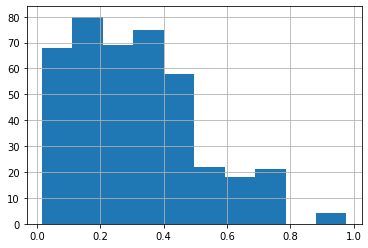

In [99]:
master["Positive_agg"].hist()

<AxesSubplot:>

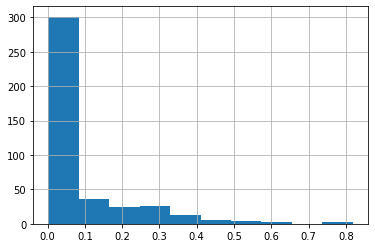

In [100]:
master["Negative_agg"].hist()

<AxesSubplot:>

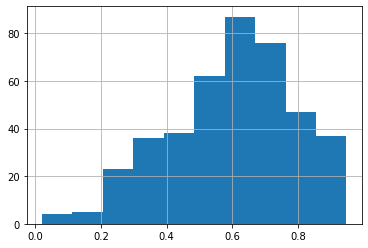

In [101]:
master["Neutral_agg"].hist()

<AxesSubplot:>

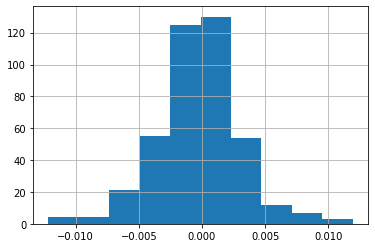

In [103]:
master["past_5min_mom"].hist()


### System level testing
Using predefined positive / negative words
https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon

In [38]:
# opening the file in read mode
my_file = open("opinion-lexicon-English/positive-words.txt", "r")
  
# reading the file
data = my_file.read()
  
# Split with new line \n
pos_words = data.split("\n")[:-1]

my_file.close()

In [44]:
# opening the file in read mode
my_file2 = open("opinion-lexicon-English/negative-words.txt", "r", encoding="ISO-8859-1")
  
# reading the file
data2 = my_file2.read()
  
# Split with new line \n
neg_words = data2.split("\n")[:-1]

my_file2.close()

In [60]:
r = random.Random(500)

In [62]:
r.choice(pos_words)

'smoothest'

In [65]:
master["manual_word"] = master["5min_ret"].apply(lambda x: random.choice(pos_words) if x>0 else random.choice(neg_words))

In [72]:
master

,time,close,created_at,Positive_agg,Neutral_agg,Negative_agg,close_after_5min,close_before_5min,5min_ret,past_5min_mom,net,manual_word,Unnamed: 0,Positive,Neutral,Negative
0,2022-11-14 09:05:00-05:00,26.5200,2022-11-14 14:05:00+00:00,0.400236,0.373861,0.225903,26.6000,26.5100,0.003017,0.000377,0.174333,statuesque,0,0.112635,0.844384,0.042981
1,2022-11-14 09:10:00-05:00,26.6000,2022-11-14 14:10:00+00:00,0.327199,0.439434,0.233367,26.3501,26.5200,-0.009395,0.003017,0.093832,scoff,1,0.294564,0.599051,0.106386
2,2022-11-14 09:15:00-05:00,26.3501,2022-11-14 14:15:00+00:00,0.445477,0.358849,0.195674,26.5000,26.6000,0.005689,-0.009395,0.249804,facilitate,2,0.152204,0.721776,0.126020
3,2022-11-14 09:20:00-05:00,26.5000,2022-11-14 14:20:00+00:00,0.349964,0.366439,0.283597,26.4100,26.3501,-0.003396,0.005689,0.066366,fumes,3,0.215004,0.683941,0.101054
4,2022-11-14 09:25:00-05:00,26.4100,2022-11-14 14:25:00+00:00,0.371188,0.346429,0.282383,26.3500,26.5000,-0.002272,-0.003396,0.088806,melodramatically,4,0.258963,0.671580,0.069457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,2022-11-18 15:35:00-05:00,27.4997,2022-11-18 20:35:00+00:00,0.250721,0.587951,0.161328,27.4599,27.4800,-0.001447,0.000717,0.089393,indifferent,410,0.145792,0.680062,0.174145
411,2022-11-18 15:40:00-05:00,27.4599,2022-11-18 20:40:00+00:00,0.339184,0.528247,0.132569,27.5100,27.4997,0.001824,-0.001447,0.206615,excels,411,0.103495,0.760180,0.136324
412,2022-11-18 15:45:00-05:00,27.5100,2022-11-18 20:45:00+00:00,0.278470,0.583988,0.137541,27.5200,27.4599,0.000364,0.001824,0.140929,cheery,412,0.341472,0.523709,0.134819
413,2022-11-18 15:50:00-05:00,27.5200,2022-11-18 20:50:00+00:00,0.296702,0.461135,0.242163,27.4999,27.5100,-0.000730,0.000364,0.054539,discomfort,413,0.057144,0.426788,0.516068


In [69]:
manual_word_scores = pd.read_csv("system_test_sent.csv")

In [71]:
master = pd.concat([master, manual_word_scores], axis=1)

## ANFIS

In [23]:
import anfis
import membership.mfDerivs
import membership.membershipfunction

In [59]:
X = master[["Positive_agg","Negative_agg","past_5min_mom"]].values
# X = master[["Positive","Negative","past_5min_mom"]].values
Y = master["5min_ret"].values

# X_train = X
# X_test = X
# y_train = Y
# y_test = Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# X = master[["Positive_agg","Negative_agg","past_10min_mom"]].values
# Y = master["10min_ret"].values

In [60]:
mf = [[['gaussmf',{'mean':1,'sigma':1}],['gaussmf',{'mean':0,'sigma':1}]],
      [['gaussmf',{'mean':1,'sigma':1}],['gaussmf',{'mean':0,'sigma':1}]],
      [['gaussmf',{'mean':1,'sigma':1}],['gaussmf',{'mean':-1,'sigma':1}]]]

In [61]:
# mf = [[['gaussmf',{'mean':0.4,'sigma':0.1}],['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.1,'sigma':0.1}]],
#       [['gaussmf',{'mean':0.4,'sigma':0.1}],['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.1,'sigma':0.1}]],
#       [['gaussmf',{'mean':0.01,'sigma':0.01}],['gaussmf',{'mean':0.,'sigma':0.01}],['gaussmf',{'mean':-0.01,'sigma':0.01}]]]

current error: 0.0031928343897473454
epoch: 2
Converged yet?: False
current error: 0.0031927882370340463
epoch: 3
Converged yet?: False
current error: 0.003192739513570231
epoch: 4
Converged yet?: False
current error: 0.0031926880118266256
epoch: 5
Converged yet?: False
current error: 0.0031926278905994006
epoch: 6
Converged yet?: False
current error: 0.003192557196796544
epoch: 7
Converged yet?: False
current error: 0.0031924733925827015
epoch: 8
Converged yet?: False
current error: 0.0031923731381074006
epoch: 9
Converged yet?: False
current error: 0.003192251978845307
epoch: 10
Converged yet?: False
current error: 0.003192103889811562
epoch: 11
Converged yet?: False
current error: 0.0031919206027983746
epoch: 12
Converged yet?: False
current error: 0.0031916906022147135
epoch: 13
Converged yet?: False
current error: 0.003191397613782261
epoch: 14
Converged yet?: False
current error: 0.0031910183236569184
epoch: 15
Converged yet?: False
current error: 0.0031905189632929166
epoch: 16


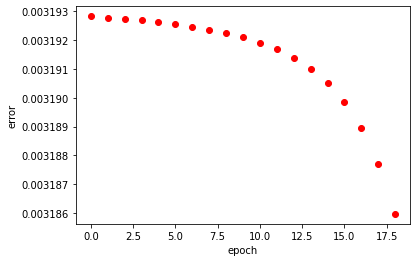

Plotting results


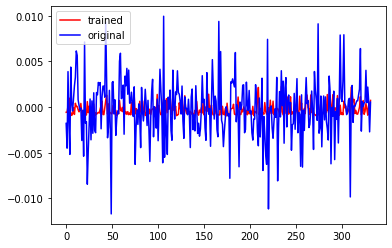

In [62]:
mfc = membership.membershipfunction.MemFuncs(mf)
anf = anfis.ANFIS(X_train, y_train, mfc)
anf.trainHybridJangOffLine(epochs=20)
print(round(anf.consequents[-1][0],6))
print(round(anf.consequents[-2][0],6))
print(round(anf.fittedValues[9][0],6))
if round(anf.consequents[-1][0],6) == -5.275538 and round(anf.consequents[-2][0],6) == -1.990703 and round(anf.fittedValues[9][0],6) == 0.002249:
    print('test is good')

print("Plotting errors")
anf.plotErrors()
print("Plotting results")
anf.plotResults()

In [49]:
anf.memFuncs

[[['gaussmf', {'mean': 1.002154510403583, 'sigma': 0.8191638923353768}],
  ['gaussmf', {'mean': -0.10884586578416075, 'sigma': 0.8039946288298485}]],
 [['gaussmf', {'mean': 1.0074940972896342, 'sigma': 0.997737722203462}],
  ['gaussmf', {'mean': -0.004007980736864466, 'sigma': 1.0260178502112844}]],
 [['gaussmf', {'mean': 0.9938020866977109, 'sigma': 1.006047045112703}],
  ['gaussmf', {'mean': -0.9844452571697854, 'sigma': 1.015440242107915}]]]

In [58]:
X.shape

(415, 3)

### Test accuracy

In [63]:
y_pred = anfis.predict(anf, X_test)

In [64]:
b = pd.DataFrame(y_pred, columns = ['pred_values'])

In [65]:
b["true_values"] = y_test.tolist()

In [66]:
b["direction"] = b["pred_values"]*b["true_values"]

In [67]:
b["same_direction"] = (b["direction"] > 0)

In [68]:
b["same_direction"].value_counts()

True     46
False    37
Name: same_direction, dtype: int64

### Save Trained model parameters

In [400]:
# save to npy file
data_X = asarray(anf.X)
data_Y = asarray(anf.Y)
data_consequents = asarray(anf.consequents)
data_mf = asarray(anf.memFuncs)

save(f'{ticker}_X.npy', data_X)
save(f'{ticker}_Y.npy', data_Y)
save(f'{ticker}_consequents.npy', data_consequents)
save(f'{ticker}_mf.npy', data_mf)

### Try SVM and Random Forrest

In [69]:
X = master[["Positive_agg","Negative_agg","past_5min_mom"]].values
# X = master[["Positive","Negative","past_5min_mom"]].values
# X = master[["Positive_agg","Negative_agg"]].values
# X = master[["past_5min_mom"]].values
Y = master["5min_ret"].values

In [70]:
Y = np.where(master["5min_ret"]>0, 1, 0)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [72]:
sc = StandardScaler()

In [73]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [74]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [75]:
pred_rfc = rfc.predict(X_test)

In [76]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.50      0.61      0.55        41
           1       0.52      0.40      0.45        42

    accuracy                           0.51        83
   macro avg       0.51      0.51      0.50        83
weighted avg       0.51      0.51      0.50        83



/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


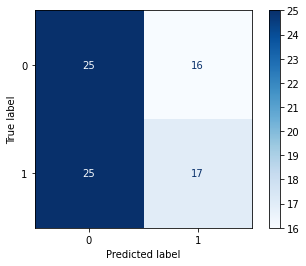

In [77]:
plot_confusion_matrix(rfc, X_test, y_test, cmap='Blues', values_format='.3g')

### Look-ahead bias

In [ ]:
X = master[["Positive_fut","Negative_fut","past_5min_mom"]].values
# X = master[["Positive_agg","Negative_agg"]].values
# X = master[["past_5min_mom"]].values
Y = master["5min_ret"].values
Y = np.where(master["5min_ret"]>0, 1, 0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
rfc_fut = RandomForestClassifier(n_estimators=200)
rfc_fut.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
pred_rfc_fut = rfc_fut.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_rfc_fut))

              precision    recall  f1-score   support

           0       0.49      0.53      0.51        40
           1       0.51      0.48      0.49        42

    accuracy                           0.50        82
   macro avg       0.50      0.50      0.50        82
weighted avg       0.50      0.50      0.50        82



/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


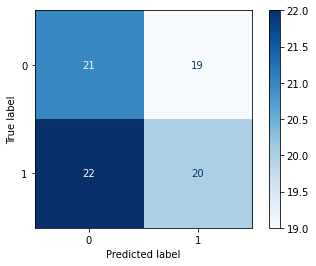

In [ ]:
plot_confusion_matrix(rfc_fut, X_test, y_test, cmap='Blues', values_format='.3g')